Data 604 Final Project: Bicycle Shop Simulation

Leticia Salazar

July 17th, 2022

##### The problem and its significance. 

The bicycle industry has boomed within the last 2 years of a global pandemic. With bicycles, parts and accessories being scarces sales and repairs have been affected along with unusual wait times, delivery delays and more. This project simulated a 'typical' day at a bicycle shop, the services they provide and wait times pre-pandemic. 

Note: this does not include phone calls and emails from customers and focusing only on in person interactions.

The simulation includes:
* Customer Arrival
* Meet with person working the floor: Depending on the type of service needed the customer will be going into one of three different service areas:
    * Random inquiries: using air pump, questions not related to the business, browsing, etc
    * Sales: looking to buy a bicycle, parts or accessories
        * Special orders: if items are not available some customers may decided to place an order (can take up to 2 days for the order to arrive)
    * Repairs: within this category there's different types of services
        * Short repair: flat fixes, minor adjustments (these usually take anywhere between 10 - 45 minutes)
        * Long repairs: tune-ups, bike assemblies, part replacements, major adjustments (these usually take between 1 hour - 1 business days)
* Normal Exit

For the time being I will be combining Sales and Special orders to be a max time of 60 minutes, Repairs(long and short) to be combined for a max of 75 minutes. All assuming they make a normal exit since in real life, a bicycle shop's simulation would require more time and an additional categories. I have provided a flow chart of what this would look like. I did attempt to make a simulation using the second flow-chart model but being fairly new using Python and SimPy I failed to make a functional model. My attempts are provided on my GitHub(link towards the end)

##### Flow-chart model.

The process is shown below diplaying the different options customers have upon arrival and first interaction with floor person.

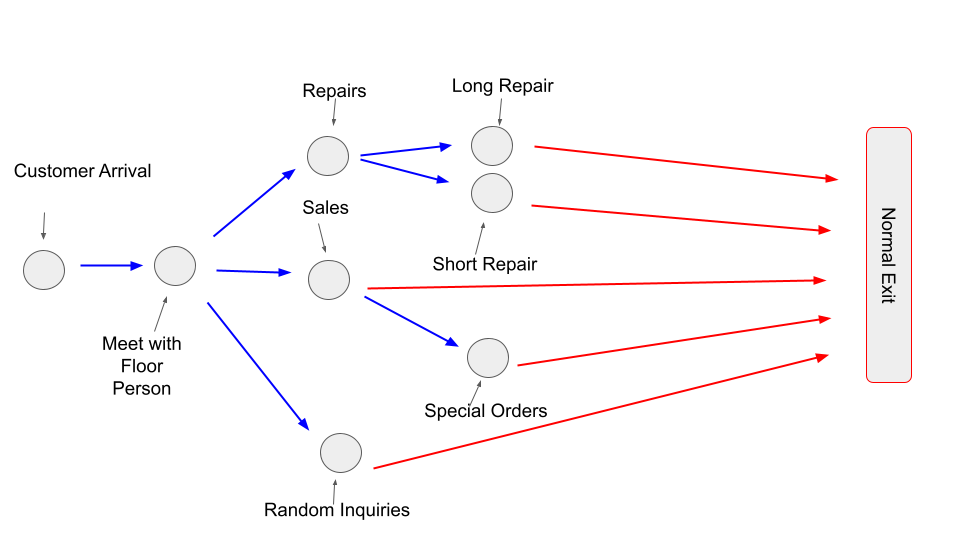

In [1]:
# Bicycle shop model modified and used for this simulation
from IPython.display import Image
Image(filename = '/Users/letiix3/Desktop/Data-604/Week_7/Sim_bike_shop.png', width = 600, height = 700)

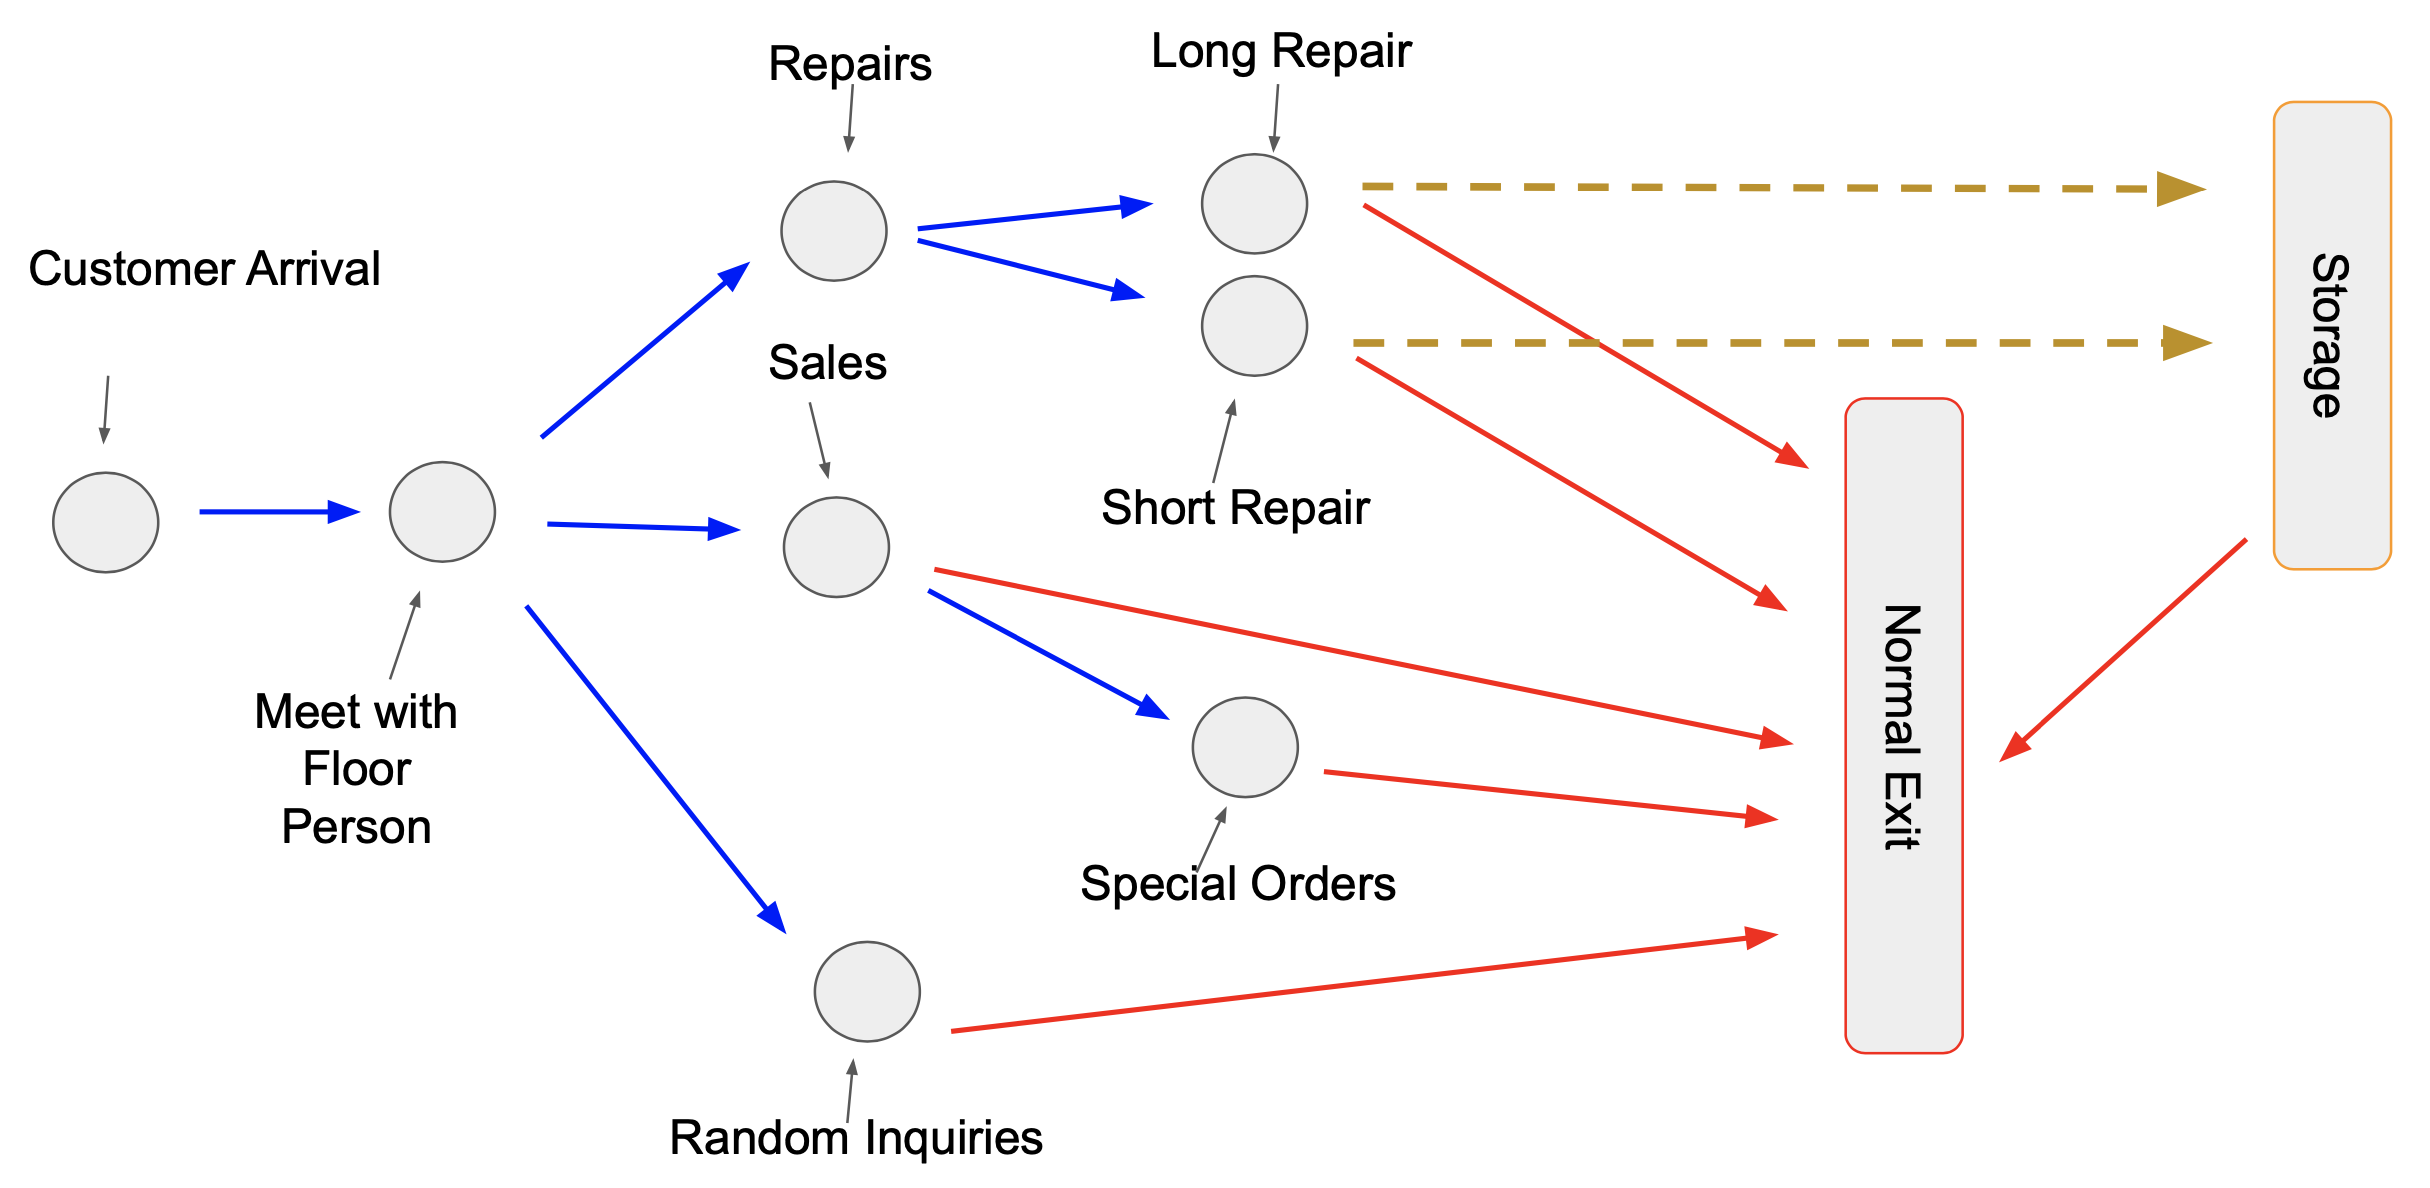

In [2]:
# Bicycle shop model initially intended to use
from IPython.display import Image
Image(filename = '/Users/letiix3/Desktop/Data-604/Week_7/bike_shop_sim.png', width = 600, height = 700)

In [3]:
# Required libraries
import simpy
import numpy as np
import pandas as pd
import random
from modsim import *
import matplotlib.pyplot as plt

In [4]:
# Setting seed and iterations
seed = 55
simulation_time = 8 # operational hours

In [5]:
np.random.seed(seed)

# Creating a data frame to later store data here
df = pd.DataFrame(columns = ['Customer Id', 'Service', 'Arrival Time', 'Floor Time', 'Service Start Time', 'Service Stop Time'])

In [6]:
# Setting customer arrival every 15 minutes from 2 - 5 customers
def customer_arrival():
    return np.random.exponential(10.0/np.random.randint(2,5))

# Setting time it takes for a customer to meet with floor person     
def meet_floor_person(self, customer):
    # min of 2 minutes and max of 10 minutes
    yield self.env.timeout(random.randint(2, 5))
    
# Setting time it takes for customer to be in repair station
def repair_service():
    return np.random.triangular(10,30,95)

# Setting time it takes for customer to be in sales station
def sales_service():
    return np.random.triangular(5,30,75)

# Setting time it takes for random inqiry to be completed
def random_service():
    return np.random.triangular(2,5,10)

In [7]:
# Defining customer's arrival time to bike shop
def bike_shop(env,  repair, sales, random):
    global current_hour
    
    # Counter for customer's
    i = 0 
    while True:
        Service = np.random.choice(['Repair', 'Sales', 'Random'], p=[0.80, 0.1, 0.1]) 
        i += 1
        yield env.timeout(customer_arrival())
        env.process(customer(env, i,  repair, sales, random, Service))

In [8]:
# Function to generate report for each customer
def customer(env, customer, repair, sales, random, Service):
    
    global df # global variable

    if Service == 'Sales':
        req = sales
    else:
        req = repair
    
    with sales.request() as request:
        arrival_time = env.now # starts the clock
        yield env.timeout(5) # Floor person generation time of 5 minutes
        floor_time = env.now # Records the time a floor person takes with a customer
        
        yield request
        
        # Service starts
        service_start_time = env.now
        
        if Service == 'Sales':
            yield env.timeout(sales_service())
        else:
            yield env.timeout(repair_service())
        service_stop_time = env.now 
        
        # Records the generated data
        row = pd.DataFrame([['Customer_{}'.format(customer), Service, arrival_time, floor_time, service_start_time, service_stop_time]],
                          columns = ['Customer Id', 'Service', 'Arrival Time', 'Floor Time','Service Start Time', 'Service Stop Time'])
       
        df = df.append(row, ignore_index = True, sort = False)
        
        # Calculate wait time
        df['Floor Time (Mins)'] = (df['Floor Time'] - df['Arrival Time'])
        df['Service Time (Mins)'] = (df['Service Stop Time'] - df['Service Start Time'])
        df['Wait Time (Mins)'] = (df['Service Start Time'] - df['Floor Time'] )


In [9]:
#Running model
def model(nruns, nrepair, nsales, nrandom): 
    
    # Initializing
    Repair=[] 
    Sales=[]
    Random=[]
    avg_wait_time = []
    sales_wait_time = []
    repair_wait_time = []
    random_wait_time = []
    global df
    for j in range(nruns):
        df = df[0:0]
        env = simpy.Environment()
        env.initial_time = 0
        
        # Assigning parameters as Resource
        repair = simpy.Resource(env, capacity=nrepair) 
        sales = simpy.Resource(env, capacity=nsales) 
        random = simpy.Resource(env, capacity=nrandom) 
        env.process(bike_shop(env, repair, sales, random))
        # Run for 8 ohours
        env.run(until = 8 * 60) 
        
        # Calculating means separately to use later on
        Sales=df[df.Service.isin(['Sales'])] 
        Repair=df[df.Service.isin(['Repair'])]
        Random=df[df.Service.isin(['Random'])]
    
        # Calculating average time
        avg_wait=df['Wait Time (Mins)'].mean() 
        avg_wait_repair=Repair['Wait Time (Mins)'].mean()
        avg_wait_sales=Sales['Wait Time (Mins)'].mean()
        avg_wait_random=Random['Wait Time (Mins)'].mean()
    
        avg_wait_time.append(avg_wait)
        sales_wait_time.append(avg_wait_sales)
        repair_wait_time.append(avg_wait_repair)
        random_wait_time.append(avg_wait_random)
        
    #Save dataframe
    new_dict = {"avg_wait": avg_wait_time, "sales_wait": sales_wait_time, "repair_wait": repair_wait_time, "random_wait": random_wait_time }
    
    global new_data
    new_data = pd.DataFrame(new_dict)
    return new_data

In [10]:
# Tesitng model and checking results
np.random.seed(56)
'''
Model shows 14 operational days with 20 repairs, 
16 sales, and 10 random inquiries
'''
model(14, 20, 16, 10)

avg_wait  sales_wait  repair_wait  random_wait
0   0.042235    0.195858     0.025780     0.000000
1   1.790983    4.131665     1.654561     0.936063
2   3.783258    4.366715     4.031626     0.567104
3   0.180093    0.733680     0.082062     0.350373
4   9.630450   11.494918     9.829776     6.057351
5   0.009679    0.146566     0.000000     0.000000
6   3.101588    3.248801     3.072176     3.160293
7   1.215796    1.510746     1.209043     0.856229
8   0.000000    0.000000     0.000000     0.000000
9   2.209349    2.263989     2.110199     3.211179
10  0.461533    0.628788     0.456106     0.314552
11  1.581971    1.095251     1.691204     1.328526
12  0.240187    0.240467     0.260546     0.000000
13  1.039800    0.946567     0.897936     3.069919

##### Justify the validity of the model and discuss how you verified it

The model was verified by trial and error, every time I adjusted the model and ran the simulation I would adjust the numbers in the model() to ensure I was getting good estimates on the waiting times for each service. After many attempts, the output model showing 30 operational days with 24 repairs, 16 sales, and 12 random inquiries indicated a good descriptor of wait times to get a service in a bike shop. To confirm the validity of this simulation is hard, since I do not know of other models out there for bike shops. Again, based on trial and error I was abe to find wait times close enough to reality (basing on my personal experience).

Below I show the data frame with multiple iterations of randomized services performed throughout the 8 hours of operation to show how the simulation performed.

In [11]:
# Showing data frame
df

Customer Id Service  Arrival Time  Floor Time  Service Start Time  \
0      Customer_1  Repair      0.827602    5.827602            5.827602   
1      Customer_2  Repair      1.460218    6.460218            6.460218   
2      Customer_3  Repair     18.031607   23.031607           23.031607   
3      Customer_8  Repair     33.726214   38.726214           38.726214   
4      Customer_4  Repair     20.885035   25.885035           25.885035   
..            ...     ...           ...         ...                 ...   
108  Customer_111   Sales    419.402834  424.402834          424.402834   
109  Customer_118  Repair    451.002898  456.002898          456.002898   
110  Customer_110  Repair    414.780941  419.780941          419.780941   
111  Customer_113  Repair    425.608045  430.608045          430.608045   
112  Customer_117  Repair    450.626926  455.626926          455.626926   

     Service Stop Time  Floor Time (Mins)  Service Time (Mins)  \
0            36.239630                5.0            30.412029   
1            41.688001                5.0            35.227783   
2            57.525271                5.0            34.493664   
3            60.079096                5.0            21.352882   
4            68.270949                5.0            42.385914   
..                 ...                ...                  ...   
108         465.573185                5.0            41.170351   
109         473.431836                5.0            17.428938   
110         476.869877                5.0            57.088936   
111         477.931794                5.0            47.323749   
112         479.863155                5.0            24.236229   

     Wait Time (Mins)  
0                 0.0  
1                 0.0  
2                 0.0  
3                 0.0  
4                 0.0  
..                ...  
108               0.0  
109               0.0  
110               0.0  
111               0.0  
112               0.0  

[113 rows x 9 columns]

##### Generate appropriate graphs (more than one) to illustrate the results and provide a PowerPoint presentation to share with your colleagues. Post this to the discussion. 

Box plot below shows the results of my model showing the average wait time in general, for sales, repair and random inquiry. As seen in the figure, the averages for all wait times fall between 0 - 1.5 minutes with a couple of outliers in sales and random inquiries being above 4 minute wait.

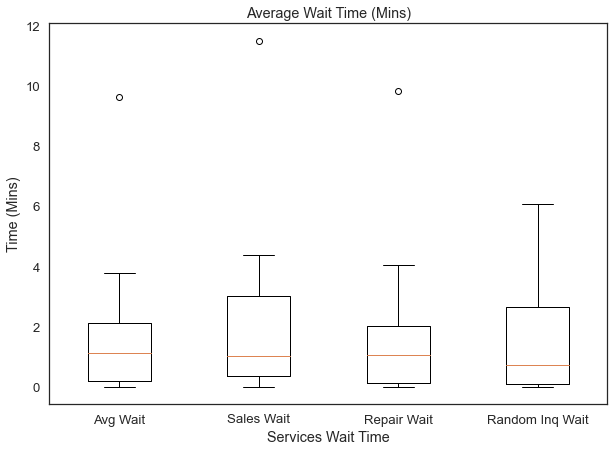

In [12]:
# Boxplot of new_data 
fig = plt.figure(figsize = (10, 7))

 
# Creating plot and labeling axis
plt.boxplot(new_data)
plt.title('Average Wait Time (Mins)')
plt.ylabel('Time (Mins)')
plt.xlabel('Services Wait Time')
plt.xticks([1,2,3,4], ['Avg Wait', 'Sales Wait', 'Repair Wait', 'Random Inq Wait'])

# Save fig
fig.savefig('boxplot_new_data_avg_wait.png')

plt.show()

The histogram below is showing the data's frequency distribution for wait time in minutes. Based on this figure, about 120 customer have a wait time of 0 - 1.5 minutes and less than 10 customers wait around 2 - 13 minutes for a service.

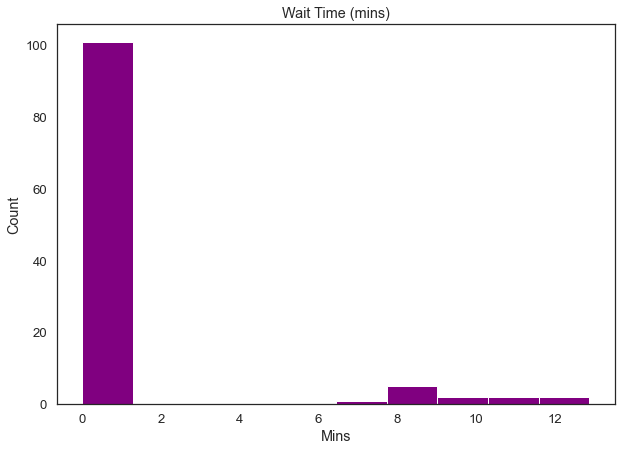

In [13]:
# Histogram of wait time in minutes
fig = plt.figure(figsize = (10,7))
plt.hist(df['Wait Time (Mins)'], color = 'purple')
plt.title('Wait Time (mins)')
plt.xlabel('Mins')
plt.ylabel('Count')

# Save fig
fig.savefig('hist_wait_time_mins.png')

plt.show()

The histogram below shows the new_data average wait also showing the majority of customers wait 0 - 4 minutes and a couple waiting between 8 - 10 minutes.

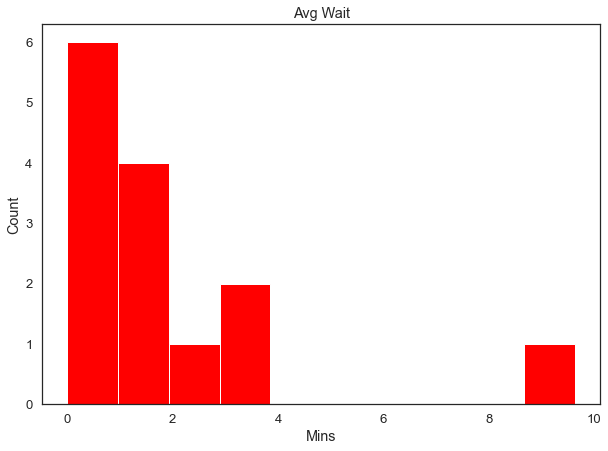

In [14]:
# Histogram of wait time in minutes
fig = plt.figure(figsize = (10,7))
plt.hist(new_data['avg_wait'], color = 'red')
plt.title('Avg Wait')
plt.xlabel('Mins')
plt.ylabel('Count')

# Save fig
fig.savefig('hist_new_data_avg_wait.png')

plt.show()

I also decided to do a line plot for the same data above showing similar results as the histogram.

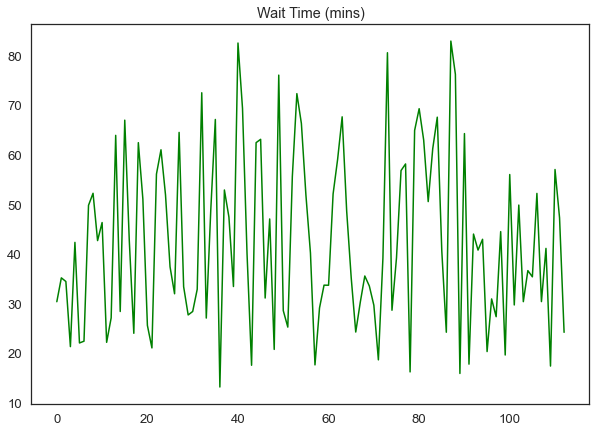

In [15]:
# Line plot of wait times in minutes
fig = plt.figure(figsize = (10,7))
plt.plot(df['Service Time (Mins)'], color = 'green')
plt.title('Wait Time (mins)')
plt.ylabel('')
plt.xlabel('')

# Save fig
fig.savefig('line_wait_time_mins.png')

plt.show()

##### State  your conclusions / findings from the model. 

Based on my model the average wait time to get a service is less than 1 minute. Majority of the customers that come in to the shop wait no more than 6 minutes to get serviced.

My model also showed some missing values for wait times for random inquiries which I found odd but looking back at my code I realized I removed the random_service out from the for loop because I kept getting errors. The errors coud have been because I wasn't placing the random inquiries properly in the for loop. After adjusting my model one more time I was able to get the wait time averages (shown below) for each service. 

With more experience or more time working on this simulation I could have improved it more and probably figure out what is wrong with my original code that didn't pan out as I wished.

In [16]:
# Print out the Averages calculated

print('Avg wait:', df['Wait Time (Mins)'].mean())

Sales = df[df.Service.isin(['Sales'])]
print('Avg time for a customer going for sales to wait is:',Sales['Wait Time (Mins)'].mean())

Repair = df[df.Service.isin(['Repair'])]
print('Avg time for a customer going for repair to wait is:',Repair['Wait Time (Mins)'].mean())

Random = df[df.Service.isin(['Random'])]
print('Avg time for a customer going for random inqury to wait is:',Random['Wait Time (Mins)'].mean())

Avg wait: 1.0398000729788297
Avg time for a customer going for sales to wait is: 0.9465665273073983
Avg time for a customer going for repair to wait is: 0.8979364502079632
Avg time for a customer going for random inqury to wait is: 3.0699190305533244


In [17]:
#new_data['avg_wait'].plot.bar(figsize = (10,7))
#Out of 22 days, average wait time exceeded 10 mins on 2 days. This is less than 10% of the time.

##### References and Links:

GitHub: https://github.com/letisalba/Data-604/tree/master/Week_7 here you can explore my attempts to run this simulation.

Code Credit: https://rpubs.com/zahirf after doing some code search I came across this person's code in rpubs. With some modifications I was able to run this simulation properly and hoping to continue to study it further to improve my coding skills.
